In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import numpy as np

In [6]:
def summarySE(data=None, measurevar=None, groupvars=None, na_rm=False, conf_interval=0.95):
    # New version of length which can handle NA's: if na_rm==True, don't count them
    def length2(x, na_rm=False):
        if na_rm:
            return np.sum(~np.isnan(x))
        else:
            return len(x)

    # This does the summary. For each group's data frame, return a DataFrame with N, mean, and sd
    def summary_fun(xx, col):
        return pd.Series({
            'N': length2(xx[col], na_rm=na_rm),
            'mean': np.mean(xx[col]),
            'sd': np.std(xx[col])
        })

    datac = data.groupby(groupvars, dropna=True).apply(summary_fun, col=measurevar).reset_index()

    # Rename the "mean" column
    datac.rename(columns={'mean': measurevar}, inplace=True)

    datac['se'] = datac['sd'] / np.sqrt(datac['N'])  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval:
    # e.g., if conf_interval is 0.95, use 0.975 (above/below), and use df=N-1
    ci_mult = t.ppf(conf_interval / 2 + 0.5, datac['N'] - 1)
    datac['ci'] = datac['se'] * ci_mult

    return datac 


# Example data (replace these paths with your actual data paths)
L1_data = {
    'subject': ['A', 'B', 'C'],
    'support': [1, 2, 1],
    'recall': [0.8, 0.6, 0.7]
}

L2_data = {
    'subject': ['A', 'B', 'C'],
    'support': [1, 2, 1],
    'recall': [0.7, 0.5, 0.6]
}

L1 = pd.DataFrame(L1_data)
L2 = pd.DataFrame(L2_data)

LINE = pd.concat([L1, L2], ignore_index=True)


In [9]:
sum_sens

,subject,support,N,recall,sd,se,ci
0,A,1,2.0,0.75,0.05,0.035355,0.449232
1,B,2,2.0,0.55,0.05,0.035355,0.449232
2,C,1,2.0,0.65,0.05,0.035355,0.449232


In [15]:
df_L1_data = pd.read_excel('exampleData/NIHMS1648953-supplement-1648953_SD_Fig_2.xlsx', sheet_name='Fig2a_one_read')
df_L2_data = pd.read_excel('exampleData/NIHMS1648953-supplement-1648953_SD_Fig_2.xlsx', sheet_name='Fig2a_two_reads')

In [42]:
LINE = pd.concat([df_L1_data, df_L2_data], ignore_index=True)
LINE['support'] = LINE['support'].str.extract('(\d+)', expand=False).astype(float)

In [43]:
LINE

,subject,sample,support,cutoff,recall,precision,FP
0,F2noMDA,Sample_316-BG-clone19,1.0,0.5,0.506423,0.947320,57
1,F2noMDA,Sample_316-clone20,1.0,0.5,0.498718,0.961285,47
2,F2noMDA,Sample_316-clone21,1.0,0.5,0.501931,0.964551,43
3,F2noMDA,Sample_316-FR-clone1,1.0,0.5,0.573609,0.987127,25
4,F2noMDA,Sample_316-FR-clone11,1.0,0.5,0.561694,0.979133,39
...,...,...,...,...,...,...,...
131,F3noMDA,Sample_320-FR-clone7,2.0,0.5,0.441807,1.000000,0
132,F3noMDA,Sample_320-FR-clone8,2.0,0.5,0.419312,1.000000,0
133,F3noMDA,Sample_320-FR-clone9,2.0,0.5,0.436522,1.000000,0
134,F3noMDA,Sample_320-FR-tissue,2.0,0.5,0.452381,0.998580,2


In [23]:
def plot_sensitivity(df):
    """
    Plot sensitivity using Seaborn and Matplotlib.

    Parameters:
    - df (pd.DataFrame): DataFrame containing sensitivity data.

    Returns:
    - None
    """

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="support",
        y="recall",
        hue="subject",
        data=df,
        dodge=True,
        palette="Set1",
        edgecolor="black",
        linewidth=0.3
    )
    
    plt.errorbar(
        x=df['support'],
        y=df['recall'],
        yerr=df['ci'],
        fmt='none',
        color='black',
        capsize=0.1,
        linewidth=0.5
    )

    plt.xlabel("")
    plt.ylabel("Sensitivity")
    plt.ylim(0, 1.05)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([0, 1], labels=[">=1 read", ">=2 reads"])
    plt.legend(title="Subject", bbox_to_anchor=(1, 1), loc='upper left')
    plt.title("A. Sensitivity")
    plt.show()

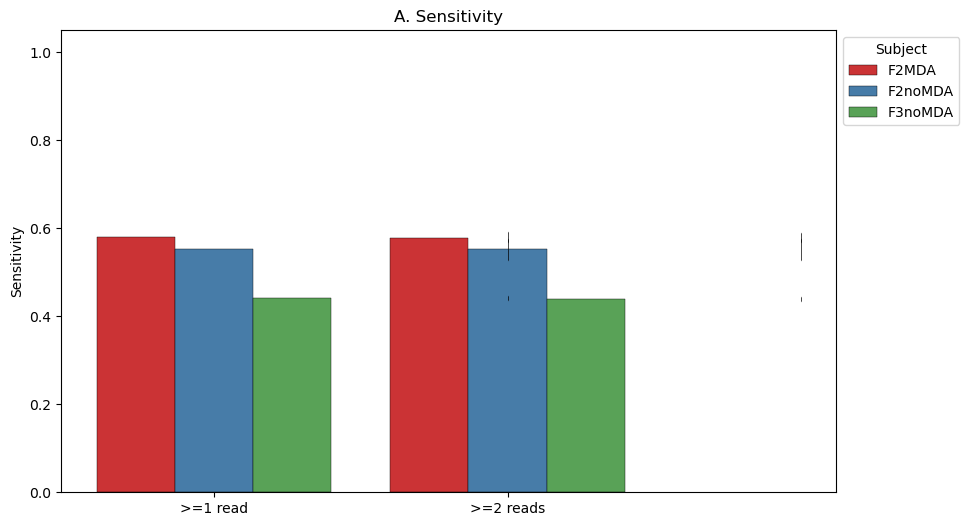

In [24]:
plot_sensitivity(summarySE(LINE, measurevar="recall", groupvars=["subject", "support"]))

In [40]:
LINE = summarySE(LINE, measurevar="recall", groupvars=["subject", "support"])

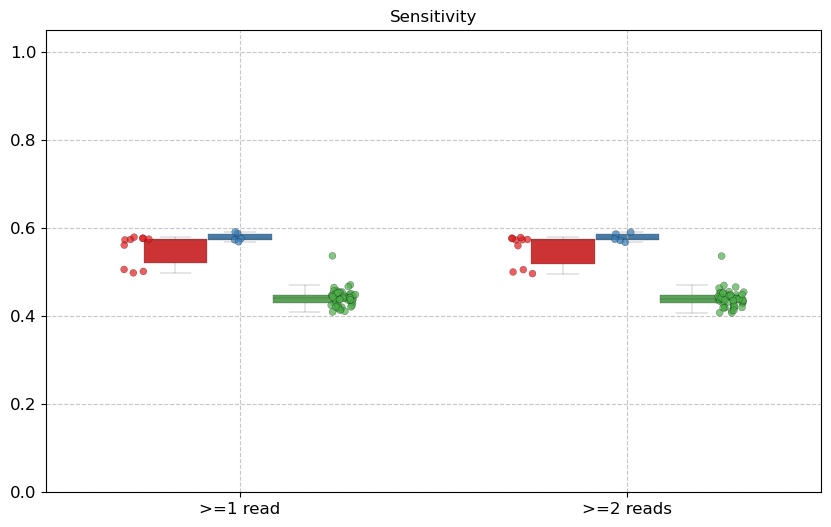

In [45]:
# Assuming LINE is a DataFrame containing the required data

# Define the color palette
cbPalette = ["#E41A1C", "#377EB8", "#4DAF4A"]

plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(x="support", y="recall", data=LINE, hue="subject", 
            width=0.5, linewidth=0.2, palette=cbPalette, fliersize=0)

# Scatter plot with jitter and dodge
#sns.scatterplot(x="support", y="recall", data=LINE, hue="subject", palette=cbPalette, s=5, legend=False)


sns.stripplot(x="support", y="recall", data=LINE, hue="subject", 
              palette=cbPalette, s=5, dodge=True,  jitter=True, 
              alpha=0.7, edgecolor='black', linewidth=0.2)

plt.xlabel("")
plt.ylabel("")
plt.ylim(0, 1.05)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks([0, 1], labels=[">=1 read", ">=2 reads"])

# Remove the legend
plt.legend().set_visible(False)

# Set the color palette for fill and color
sns.set_palette(cbPalette)

plt.grid(True, linestyle='--', alpha=0.7)

plt.title("Sensitivity")

# Adjust font sizes
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=24)

plt.show()

In [49]:
def plot_sensitivity_boxstrip(df, x_column, y_column, palette):
    """
    Plot sensitivity using Seaborn with boxplot and stripplot.

    Parameters:
    - df (pd.DataFrame): DataFrame containing sensitivity data.
    - x_column (str): Column for the x-axis.
    - y_column (str): Column for the y-axis.
    - palette (list): Color palette for the plot.

    Returns:
    - None
    """

    plt.figure(figsize=(10, 6))

    # Boxplot
    sns.boxplot(x=x_column, y=y_column, data=df, hue="subject",
                width=0.5, linewidth=0.2, palette=palette, fliersize=0)

    # Scatter plot with jitter and dodge
    sns.stripplot(x=x_column, y=y_column, data=df, hue="subject",
                  palette=palette, s=5, dodge=True, jitter=True,
                  alpha=0.7, edgecolor='black', linewidth=0.2)

    plt.xlabel("")
    plt.ylabel("")
    plt.ylim(0, 1.05)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([0, 1], labels=[">=1 read", ">=2 reads"])

    # Remove the legend
    plt.legend().set_visible(False)

    # Set the color palette for fill and color
    sns.set_palette(palette)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.title("Sensitivity")

    # Adjust font sizes
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('axes', labelsize=24)

    plt.show()

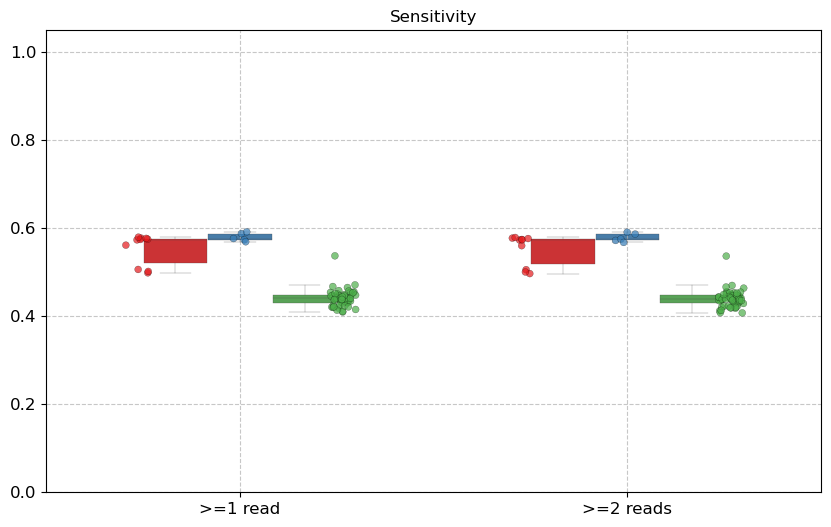

In [50]:
plot_sensitivity_boxstrip(LINE,"support","recall",cbPalette)

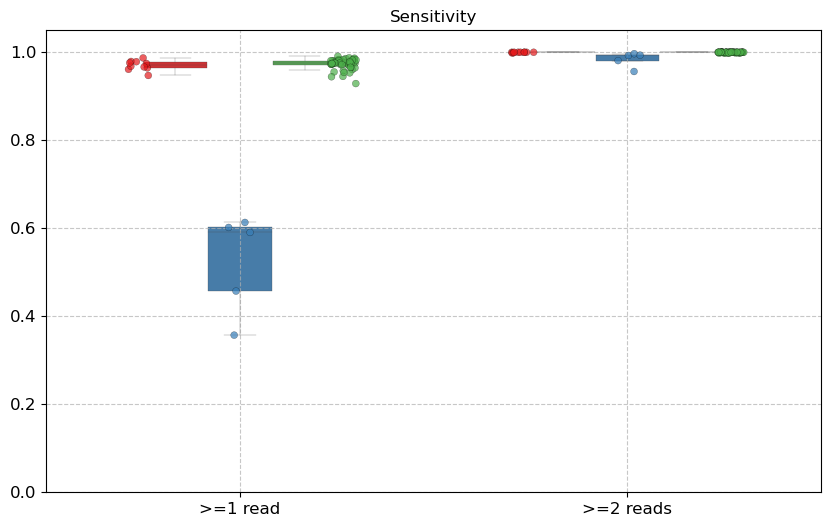

In [51]:
plot_sensitivity_boxstrip(LINE,"support","precision",cbPalette)